In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

import numpy as np

In [2]:
# read in data and turn to tensor

class JointDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

df = pd.read_csv("mldata_log_est.csv")
colnames = df.columns
X = df[colnames[:-1]].to_numpy(dtype=float)
y = df[colnames[-1]].to_numpy(dtype=float)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=3)

class StandardScaler():
    def __init__(self):
        self.fake = True
    def fit_transform(self,n):
        return n
    def transform(self,n):
        return n

sc_x = StandardScaler()
sc_y = StandardScaler()

X_train_std = sc_x.fit_transform(X_train)
y_train_std = sc_y.fit_transform(y_train.reshape(-1,1))

X_valid_std_tensor = torch.from_numpy(sc_x.transform(X_val))
y_valid_std_tensor = torch.from_numpy(sc_y.transform(y_val.reshape(-1,1)))

X_test_std_tensor = torch.from_numpy(sc_x.transform(X_test))

X_train_std_tensor = torch.from_numpy(X_train_std)
y_train_std_tensor = torch.from_numpy(y_train_std)

train_ds = JointDataset(X_valid_std_tensor, y_train_std_tensor)
valid_ds = JointDataset(X_valid_std_tensor, y_train_std_tensor)

batch_size=400 # can do 3, 9697, 
train_dl = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(dataset=valid_ds, batch_size=batch_size, shuffle=False)

In [3]:
# Just checking if my GPU has CUDA capability. It does not :/

torch.cuda.is_available()

False

In [4]:
# Making the model

torch.manual_seed(426236434)

class zGuess_dNN(nn.Module):
    def __init__(self):
        super().__init__()
        # got idea from https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-create-a-neural-network-for-regression-with-pytorch.md
        o1 = 35
        o2 = 14
        o3 = 1
        self.layers = nn.Sequential(
            nn.Linear(7,o1),
            nn.Dropout(p=0.3),
            nn.Linear(o1,o2),
            nn.Dropout(p=0.2),
            nn.Linear(o2,o3)
        )
    def forward(self, x):
        return self.layers(x)
    
model = zGuess_dNN()
loss_fn = nn.MSELoss(reduction='mean')
learning_rate = 0.00008
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [5]:
# Training

num_epochs = 2500

mse_train_arr = []
mse_val_arr = []
epoch_arr = []
for epoch in range(num_epochs):
    model.train()
    losses = []
    for x_batch, y_batch in train_dl:
        pred = model(x_batch.float())
        loss = loss_fn(pred, y_batch.float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        losses.append(loss.cpu().detach().numpy())
        
    mse_train_arr.append(np.mean(losses))
    epoch_arr.append(epoch)
    
    model.eval()
    losses = []
    for x_batch, y_batch in valid_dl:
        pred = model(x_batch.float())
        loss = loss_fn(pred, y_batch.float())
        losses.append(loss.cpu().detach().numpy())
        
    mse_val_arr.append(np.mean(losses))
    

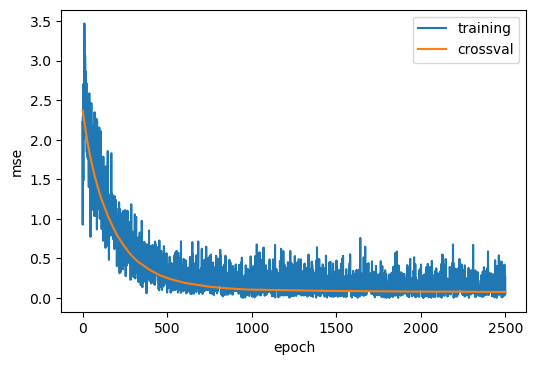

In [6]:
fig, ax = plt.subplots(1,1,dpi=100)
ax.plot(epoch_arr, mse_train_arr, label="training")
ax.plot(epoch_arr, mse_val_arr,   label="crossval")
ax.set_xlabel("epoch")
ax.set_ylabel("mse")
ax.legend()

In [7]:
y_pred_tensor = model(X_test_std_tensor.float())
y_pred = y_pred_tensor.cpu().detach().numpy()
print( "MSE:",mean_squared_error( y_test, y_pred))#sc_y.inverse_transform(y_pred) ) )
print( "R2",r2_score(  y_test, y_pred))#sc_y.inverse_transform(y_pred) ) )
print("y_test y_pred")
print("--------------")
for i in range(10):
    print(y_test[i], y_pred[i][0])#sc_y.inverse_transform(y_pred)[i][0])

MSE: 1.641896642740769
R2 -0.5495705653427323
y_test y_pred
--------------
1.2567333333333337 0.9152877
1.7228833333333335 0.6490306
3.8301833333333337 0.5128425
1.8865833333333333 0.71118516
1.5555666666666668 0.1259087
0.1546666666666666 0.0207966
0.8880666666666667 0.5249455
4.708033333333333 0.5402624
0.9247 0.38609207
0.3157166666666667 0.38249913


In [8]:
y_pred[0]

array([0.9152877], dtype=float32)